# Classifying Sentiments of Covid-19 Contact Tracing Apps with Random Forest and Logistic Regression

In the following code, I prepare the Covid-review app data, tune the hyperparamters, compare a BoW and TF-IDF featurization approach, then build respective Random Forest and Logistic Regression Models 

Goal: To classify positve vs. negative sentiments towards Covid-19 apps based on app reviews and ratings 

* [EDA of review data](#eda)
* [Classifying Positive vs. Negative Reviews](#classify)
* [Text Processing](#process)
* [Splitting Data into Test and Train](#split)
* [Random Forest and Featurization](#RF)
    * [Random Forest with BoW](#RFBow)
        * [Performance: AUC Score](#AUC1)
    * [Random Forest with TF-IDF](#RFTF)
        * [Performance: AUC Score](#AUC2)
* [Logistic Regression and Featurization](#LR)
    * [Logistic Regression with BoW](#BowLR)
        * [Performance: AUC Score](#AUC3)
    * [Logistic Regression with TF-IDF](#TFLR)
        * [Performance: AUC Score](#AUC4)
* [Summary of Findings](#summary)
    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re


# EDA of review data  <a class="anchor" id="eda"></a>

Before we prepare the text and build the model, we'll explore the data first 

In [2]:
reviews = pd.read_csv('USCanada_reviews210422.csv')

In [313]:
reviews.head()

,title,rating,date,review,userName,state,app_name,store,developerResponse
0,"Easy to set up, but, needs a tiny bit more work.",4,2020-08-18 17:59:04,The only thing I wish this app would let me co...,FleetKitten,Alabama,Guidesafe,Apple,NaN
1,Great concept and needed tool - but does not w...,1,2020-09-18 03:42:31,***Update*** My husband tested positive 2 day...,Sarah54387,Alabama,Guidesafe,Apple,NaN
2,Privacy-preserving COVID contact tracing,5,2020-08-17 21:42:26,This is the official Alabama Department of Pub...,Scott Schram,Alabama,Guidesafe,Apple,NaN
3,Great idea but does not work,1,2021-01-22 21:29:56,Both my wife and me have GuideSafe installed o...,Jimbotjr,Alabama,Guidesafe,Apple,NaN
4,Would be helpful if not for issues,1,2020-12-27 01:43:57,I have had this app for a few months and last ...,Smhlol123,Alabama,Guidesafe,Apple,NaN


The most relevant columns are review and rating for us because we want to understand the sentiments in the review text as well as how this is related to the rating. Specifically, we expect that whatever people say (positive or negative) should be reflected in the rating. Thus, using more positive words should lead to more positive reviews. 

In [314]:
reviews.shape

(10013, 9)

In [315]:
reviews.isnull().sum()

title                8090
rating                  0
date                    0
review                  0
userName                0
state                   0
app_name                0
store                   0
developerResponse    6803
dtype: int64

As we can see, there are no null values in the relevant colum (review). We are not using the title or developer Response column so it doesn't matter that we have NAs 

In order to even see how the apps ratings are overall, we'll plot the ratings column first

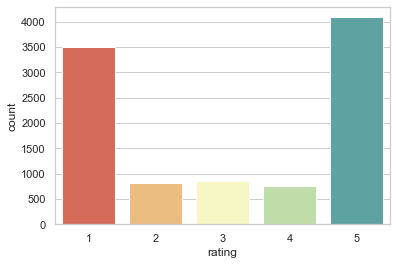

In [316]:
# plot the ratings 

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme(style="whitegrid")
rating_plot= sns.countplot(x="rating",data=reviews, palette= "Spectral")



As we can see from this graph, the scoring seems to be rather extreme. Either people hate or love the respective contact tracing apps 

# Classifying Positive vs. Negative Reviews <a class="anchor" id="classify"></a>

Next, we are going to classify the reviews. Given we have the reviews, we can classify them into "positive", "negative", and "neutral". 

This will be used as training data for our sentiment classifciation model

Reviews that have scores 1,2,3 will be assigned a negative sentiment
reviews with scores 4 and 5 will be positive 

In [3]:
def sentiment(n):
    return 1 if n > 3 else 0
reviews['sentiment'] = reviews['rating'].apply(sentiment)
reviews.head()

,title,rating,date,review,userName,state,app_name,store,developerResponse,sentiment
0,"Easy to set up, but, needs a tiny bit more work.",4,2020-08-18 17:59:04,The only thing I wish this app would let me co...,FleetKitten,Alabama,Guidesafe,Apple,NaN,1
1,Great concept and needed tool - but does not w...,1,2020-09-18 03:42:31,***Update*** My husband tested positive 2 day...,Sarah54387,Alabama,Guidesafe,Apple,NaN,0
2,Privacy-preserving COVID contact tracing,5,2020-08-17 21:42:26,This is the official Alabama Department of Pub...,Scott Schram,Alabama,Guidesafe,Apple,NaN,1
3,Great idea but does not work,1,2021-01-22 21:29:56,Both my wife and me have GuideSafe installed o...,Jimbotjr,Alabama,Guidesafe,Apple,NaN,0
4,Would be helpful if not for issues,1,2020-12-27 01:43:57,I have had this app for a few months and last ...,Smhlol123,Alabama,Guidesafe,Apple,NaN,0


In [4]:
positive = reviews[reviews['sentiment'] == 1]
negative = reviews[reviews['sentiment'] == 0]

In [5]:
# removing stop words 

stop = set(stopwords.words('english'))
stop.update(["app","Covid", 'people', 'phone', 'work', 'need', 'get', 'use', 'know', 'would'])
print(stop)

{'after', 'wasn', 'shouldn', 'down', 'you', 'but', 'when', 'its', 'for', 'before', 'they', 've', 'until', 'above', 'own', 's', 'doing', 'hasn', "won't", 'her', "hasn't", 'hadn', "wouldn't", 'yourself', 'most', 'then', 'the', 'mightn', 'he', "didn't", 'needn', 'by', 'ours', 'ourselves', 'over', 'aren', 'who', 'yours', 'few', 'we', 'other', 'o', 'didn', 'were', 'theirs', 'did', 'against', 'she', "doesn't", 'as', 'through', 'more', 'out', 'again', 'will', 'that', 'be', 'wouldn', 'why', 'Covid', 'had', 'where', 'only', 'your', 'because', "haven't", 'app', 'it', 'get', 'and', 'has', 'during', 'or', 't', 'which', 'under', "should've", 'in', 'him', 'doesn', 'isn', 'both', "wasn't", 'those', 'with', 'being', 'me', 'at', 'll', 'what', 're', 'phone', 'all', "you'd", 'was', 'an', 'work', 'need', 'been', 'mustn', "shouldn't", 'couldn', 'having', 'such', 'ma', 'haven', 'himself', 'these', 'hers', "she's", "it's", 'same', 'below', 'from', 'use', 'off', 'y', 'a', 'would', 'am', 'of', "that'll", 'can'

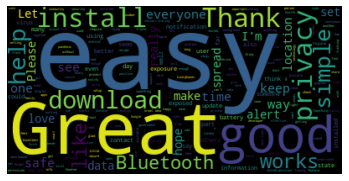

In [6]:
pos = " ".join(review for review in positive.review)
stop.update(["app","Covid", 'people', 'phone', 'work', 'need', 'get', 'use', 'know', 'would'])
wordcloud2 = WordCloud(stopwords=stop).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

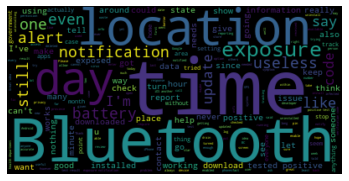

In [7]:
neg = " ".join(review for review in negative.review)
wordcloud2 = WordCloud(stopwords=stop).generate(neg)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

# Text Processing  <a class="anchor" id="process"></a>

In order to get the data ready for our sentiment analysis, we need to preprocess the text of the reviews. 
This includes 

1. Stem the words 
2. Remove punctation
3. Convert to lower case 
4. removing numbers 
5. lower case 

In [8]:
# We are just going to look at random review to see what it looks like right now 

test_r = reviews['review'].values[366]
test_r 

'I just moved to NYC and was super scared about getting Covid. This app, if enough people download it, will be able to accurately tell me if I’ve been by someone who tested positive. That way I can quarantine and make sure I don’t hurt the people I love.\n\nThis app uses Apple and Googles PRIVATE framework and I am sure they have done everything in their power to make sure it doesn’t store any of my sensitive material.'

In [9]:
# stemming 
sno = nltk.stem.SnowballStemmer('english')


In [10]:
# function to remove punctuation 
def cleanpunc(sentence) :
    cleaned=re.sub(r'[? | ! | \' |" | #]',r'',sentence)
    cleaned=re.sub(r'[. | , | ) | ( | \ | / ]' ,r' ',sentence)
    return cleaned

In [11]:
# remove numbers  
re.sub("\S*\d\S*", "", test_r).strip()
print(test_r)

I just moved to NYC and was super scared about getting Covid. This app, if enough people download it, will be able to accurately tell me if I’ve been by someone who tested positive. That way I can quarantine and make sure I don’t hurt the people I love.

This app uses Apple and Googles PRIVATE framework and I am sure they have done everything in their power to make sure it doesn’t store any of my sensitive material.


In [12]:
# remove special charactrs 
re.sub('[^A-Za-z0-9]+', ' ', test_r)

'I just moved to NYC and was super scared about getting Covid This app if enough people download it will be able to accurately tell me if I ve been by someone who tested positive That way I can quarantine and make sure I don t hurt the people I love This app uses Apple and Googles PRIVATE framework and I am sure they have done everything in their power to make sure it doesn t store any of my sensitive material '

In [13]:
# now that we have come up with all commands and functions, we'll put it in a loop 


from tqdm import tqdm

i = 0
str1 = ' '
preprocessed_reviews = []
all_positive_words = [] #store words from +ve reviews here
all_negative_words = [] # store words from -ve reviews here
s = ''


for sentence in tqdm(reviews['review'].values):
    filtered_sentence=[]
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    # sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    for w in sentence.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (reviews['sentiment'].values[i]) == 1 :
                      all_positive_words.append(s) #list all the positive words
                    if (reviews['sentiment'].values[i]) == 0 :
                       all_negative_words.append(s) #list all the negative words
                else:
                    continue
            else:
                continue
    #print(filtered_sentence)
    str1=b" ".join(filtered_sentence) #final string of the filtered sentence
    
    preprocessed_reviews.append(str1.strip())
    i+=1



100%|██████████| 10013/10013 [00:04<00:00, 2344.46it/s]


In [16]:
# make a new column with the preprocessed reviews 

reviews['preprocessed_reviews'] = preprocessed_reviews
reviews['preprocessed_reviews'] = reviews['preprocessed_reviews'].str.decode("utf-8")

In [17]:
reviews.head()

,title,rating,date,review,userName,state,app_name,store,developerResponse,sentiment,preprocessed_reviews
0,"Easy to set up, but, needs a tiny bit more work.",4,2020-08-18 17:59:04,The only thing I wish this app would let me co...,FleetKitten,Alabama,Guidesafe,Apple,NaN,1,thing wish let consent access io health routin...
1,Great concept and needed tool - but does not w...,1,2020-09-18 03:42:31,***Update*** My husband tested positive 2 day...,Sarah54387,Alabama,Guidesafe,Apple,NaN,0,updat husband test posit day ago immedi report...
2,Privacy-preserving COVID contact tracing,5,2020-08-17 21:42:26,This is the official Alabama Department of Pub...,Scott Schram,Alabama,Guidesafe,Apple,NaN,1,offici alabama depart public health privaci pr...
3,Great idea but does not work,1,2021-01-22 21:29:56,Both my wife and me have GuideSafe installed o...,Jimbotjr,Alabama,Guidesafe,Apple,NaN,0,wife guidesaf instal iphon wife sick went got ...
4,Would be helpful if not for issues,1,2020-12-27 01:43:57,I have had this app for a few months and last ...,Smhlol123,Alabama,Guidesafe,Apple,NaN,0,month last night first time actual open look s...


In [ ]:
all_positive_words

In [ ]:
all_negative_words

# Splitting data into Train and Test  <a class="anchor" id="split"></a>

In [18]:
# use preprocessed_reviews and sentiment 

X = reviews['preprocessed_reviews'].values
Y = reviews['sentiment'].values

In [19]:
print(X.shape)
print(Y.shape)

(10013,)
(10013,)


In [20]:
# splitting 

from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2, random_state=1234)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8010,) (8010,)
(2003,) (2003,)


# Random Forest and Featurization <a class="anchor" id="RF"></a>

This section will build a RF model with 2 different featurization approaches: BoW and TF-IDF.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
import graphviz as gz
import plotly.offline as offline
import plotly.graph_objs as go

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.testing as tm
import math


## BoW Featurization 

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
Vect = CountVectorizer() 


Bow_train = Vect.fit_transform(X_train)
Bow_test = Vect.transform(X_test)

print(Bow_train.shape,Y_train.shape)
print(Bow_test.shape,Y_test.shape)

(8010, 5885) (8010,)
(2003, 5885) (2003,)


## Random Forest with BoW Featurization <a class="anchor" id="RFBow"></a>

Tune hyperparameters of RF

In [41]:
# First we are going to write a function to tune our hyperparameters for the RF 

def Grid_search_RF(model,X_train,Y_train):
    estimators = [50,100,200,300,400,500,600]
    depths = [10,20,30,40,50,60,70]

    hyperF = dict(n_estimators = estimators, max_depth = depths)
    gridF = GridSearchCV(model1, hyperF, cv = 3, verbose = 1,  scoring = 'roc_auc', 
                      n_jobs = -1, return_train_score=True)
    bestF = gridF.fit(X_train, Y_train)
    
    print("\n**********AUC Score for data **********\n")
    print("\nOptimal depth:", bestF.best_estimator_.max_depth)
    print("\nOptimal estimators:", bestF.best_estimator_.n_estimators)
    print("\nBest Score:", bestF.best_score_)

    sns.set()
    df_gridsearch = pd.DataFrame(gridF.cv_results_)
    max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
    max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
    sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
    plt.show()

    


##### GridSearch for RF with BoW

Use function tune our RF base model


**********AUC Score for CV data **********


Optimal depth: 60

Optimal estimators: 500

Best Score: 0.8869698046149784


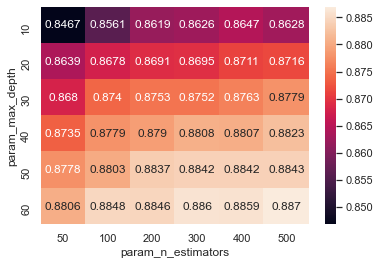

In [42]:
import warnings

#gridsearch for optimal depth and estimators 

model1 = RandomForestClassifier()

Grid_search(model1,Bow_train,Y_train)



As we can see here, the optimal depth and estimators are: 60 and 500

We are passing the tuned parameters to our RF model  


In [87]:
# turn optimal depth and n_estimators into variables 

depth_1 = 60
estimators_1 = 500

model1_tuned = RandomForestClassifier(max_depth = depth_1, n_estimators = estimators_1,class_weight='balanced')

Now we are going to write a function that can be used to test our data and produce a ROC_AUC curve 

In [45]:
from sklearn.metrics import roc_curve, auc

def test_data(model,x_train,y_train,x_test,y_test):
    model.fit(x_train, y_train)

    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])

    sns.set()
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.plot([0, 1], [0, 1], color='green', lw=1, linestyle='--')
    plt.legend()
    plt.xlabel("False_positive_rate")
    plt.ylabel("True positive_rate")    
    plt.title("ROC_Curve")
    plt.grid()
    plt.show()
    print('The AUC_score of test_data is :',auc(test_fpr, test_tpr))

## AUC_ROC Curve for RF with BoW  <a class="anchor" id="AUC1"></a>


Now we are going to use the just created function to test the data on our tuned RF model 

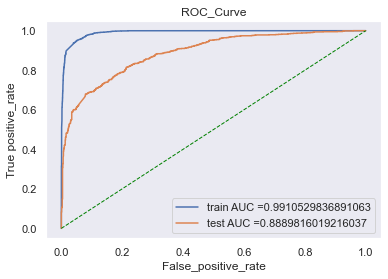

The AUC_score of test_data is : 0.8889816019216037


In [46]:
#### testing with the test data

# model1_tuned is our tuned RF model --> we will use that in our function now
 
test_data(model1_tuned,Bow_train,Y_train,Bow_test,Y_test)


We can also create a confusion matrix. Again, we'll write a function that we can use later for other models

In [47]:
#Confusion matrix 

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def perform(model,x_train,y_train,x_test,y_test):
    
    model.fit(x_train, y_train)
    predict = model.predict(x_test)

    conf_mat = confusion_matrix(y_test, predict)
    class_label = ["Negative", "Positive"]
    df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
    
    report = classification_report(y_test,predict)
    print(report)
    
    sns.set()
    sns.heatmap(df, annot = True,fmt="d")
    plt.title("Test Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1024
           1       0.79      0.79      0.79       979

    accuracy                           0.79      2003
   macro avg       0.79      0.79      0.79      2003
weighted avg       0.79      0.79      0.79      2003



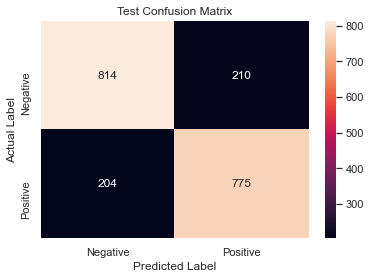

In [48]:
# Let's look at the classifcation report and confusion matrix 
# Again we are using our model1_tuned 

perform(model1_tuned,Bow_train,Y_train,Bow_test,Y_test)

Having tried the RF with BoW, we are now trying a different featurization apporach. 

# Random Forest with TFIDF Featurization  <a class="anchor" id="RFTF"></a>




Next, we are using the tfidf Vectorizer and transform our test and train data according to that 

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

# first we are vectorizing our data with the TFIDF approach 
tf_idf = TfidfVectorizer() 

Train_tf_idf = tf_idf.fit_transform(X_train)
Test_tf_idf = tf_idf.transform(X_test)

print(Train_tf_idf.shape,Y_train.shape)
print(Test_tf_idf.shape,Y_test.shape)

(8010, 5885) (8010,)
(2003, 5885) (2003,)


##### GridSearch for RF with TFIDF 

Next we use the function created earlier to tune our RF base model

Fitting 3 folds for each of 49 candidates, totalling 147 fits

**********AUC Score for data **********


Optimal depth: 70

Optimal estimators: 400

Best Score: 0.8834299558866557


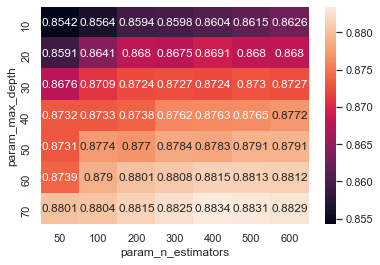

In [51]:
#gridsearch for optimal depth and estimators 
# we are going to use our base model (model1) again to do a GridSearch

Grid_search_RF(model1,Train_tf_idf,Y_train)


In [53]:
# turn optimal depth and n_estimators into variables 
# then we created a new tuned RF model with TFIDF featurization 

depth_2 = 70
estimators_2 = 400

model2_tuned = RandomForestClassifier(max_depth = depth_2, n_estimators = estimators_2,class_weight='balanced')

## AUC-Score for RF with TF-IDF <a class="anchor" id="AUC2"></a>


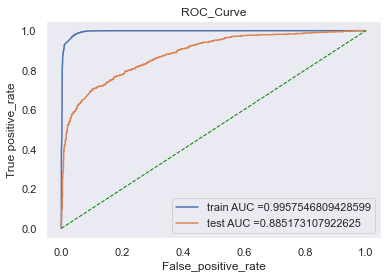

The AUC_score of test_data is : 0.885173107922625


In [54]:
#testing with the test data

# we are using our tuned model2_tuned to test now 

# use function 
test_data(model2_tuned ,Train_tf_idf,Y_train,Test_tf_idf,Y_test)


              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1024
           1       0.81      0.76      0.78       979

    accuracy                           0.79      2003
   macro avg       0.80      0.79      0.79      2003
weighted avg       0.80      0.79      0.79      2003



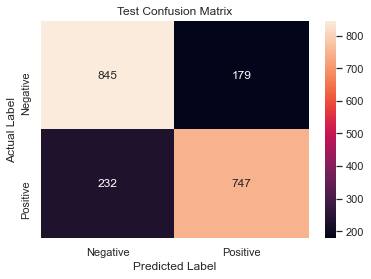

In [55]:
# performance metric 
# again using the model2_tuned and our created function 


perform(model2_tuned,Train_tf_idf,Y_train,Test_tf_idf,Y_test)

# Featurization and Logistic Regression  <a class="anchor" id="LR"></a>



In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
# create base LR model 

model3 = LogisticRegression()


### We are going to use the Bow test and train data that we created above. <a class="anchor" id="BowLR"></a>
So we are just going to use the Bow_train and Bow_test datasets:


In [94]:
# here are the Bow datasets again 
print(Bow_train.shape,Y_train.shape)
print(Bow_test.shape,Y_test.shape)

(8010, 5885) (8010,)
(2003, 5885) (2003,)


We are also going to tune the hyperparameters of the LR: instead of applying the LR as is, we can also improve its performance by tuning the hyperparameters through GridSearch 

### Create function for GridSearch for the LR 

In [76]:
from sklearn.model_selection import RepeatedStratifiedKFold

def Grid_search_LR(model,X_train,Y_train):
    # define evaluation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define search space
    space = dict()
    space['solver'] = ['lbfgs', 'liblinear', 'newton-cg']
    space['penalty'] = ['l1', 'l2', 'elasticnet']
    space['C'] = np.logspace(-4,4,20)
    # define search
    search = GridSearchCV(model, space, scoring='roc_auc', n_jobs=-1, cv=cv)
    # execute search
    result = search.fit(X_train, Y_train)
    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    
    
    

### GridSearch for LR with BoW

In [77]:
Grid_search_LR(model3,Bow_train,Y_train) 

/Users/stefanien/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning:

One or more of the test scores are non-finite: [       nan 0.5               nan 0.8267886  0.82236722 0.82678548
        nan        nan        nan        nan 0.5               nan
 0.83129943 0.83009121 0.83129985        nan        nan        nan
        nan 0.5               nan 0.83959891 0.84056829 0.83959974
        nan        nan        nan        nan 0.5               nan
 0.85088371 0.85177485 0.8508833         nan        nan        nan
        nan 0.60455041        nan 0.86285178 0.86310896 0.86285116
        nan        nan        nan        nan 0.78965672        nan
 0.87302558 0.87307843 0.87302495        nan        nan        nan
        nan 0.82980947        nan 0.88040901 0.8804036  0.88040943
        nan        nan        nan        nan 0.85897872        nan
 0.88483127 0.8848348  0.88483189        nan        nan        nan
        nan 0.87545422        nan 0.

Best Score: 0.8858887186368488
Best Hyperparameters: {'C': 0.23357214690901212, 'penalty': 'l2', 'solver': 'newton-cg'}


We now use our tuned BoW with our tuned LR parameters and see how our model performs on the test data

## AUC Score for LR with BoW   <a class="anchor" id="AUC3"></a>

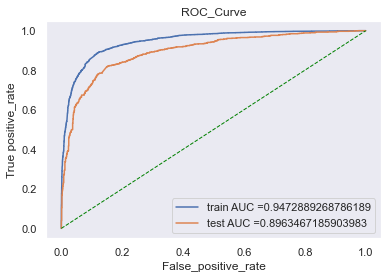

The AUC_score of test_data is : 0.8963467185903983


In [79]:
model3_tuned = LogisticRegression(C = 0.23357, solver = 'newton-cg', penalty = 'l2') # with auc_score

test_data(model3_tuned,Bow_train,Y_train,Bow_test,Y_test)

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1024
           1       0.83      0.82      0.83       979

    accuracy                           0.83      2003
   macro avg       0.83      0.83      0.83      2003
weighted avg       0.83      0.83      0.83      2003



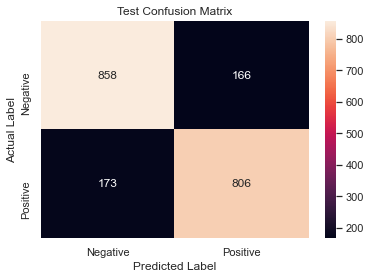

In [81]:
#performance metric 

perform(model3_tuned,Bow_train,Y_train,Bow_test,Y_test)

## Featurization with TFIDF for LR  <a class="anchor" id="TFLR"></a>

We are using the TFIDF vectorization again as before (from RF) 

In [82]:

print(Train_tf_idf.shape,Y_train.shape)
print(Test_tf_idf.shape,Y_test.shape)

(8010, 5885) (8010,)
(2003, 5885) (2003,)


### Gridsearch fo LR with TFIDF

In [83]:
Grid_search_LR(model3, Train_tf_idf,Y_train) 

/Users/stefanien/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning:

One or more of the test scores are non-finite: [       nan 0.5               nan 0.87027702 0.8687317  0.87027702
        nan        nan        nan        nan 0.5               nan
 0.87048342 0.86912245 0.87036025        nan        nan        nan
        nan 0.5               nan 0.87056831 0.86980158 0.87056831
        nan        nan        nan        nan 0.5               nan
 0.87107391 0.87072539 0.87107391        nan        nan        nan
        nan 0.5               nan 0.87241405 0.87225155 0.87241405
        nan        nan        nan        nan 0.54704846        nan
 0.87534319 0.87525081 0.87534298        nan        nan        nan
        nan 0.70073416        nan 0.88053878 0.88053877 0.88053836
        nan        nan        nan        nan 0.8307008         nan
 0.88783667 0.8878248  0.88783521        nan        nan        nan
        nan 0.86570223        nan 0.

Best Score: 0.9047973895132047
Best Hyperparameters: {'C': 1.623776739188721, 'penalty': 'l2', 'solver': 'lbfgs'}


Having tuned our hyperparameters, we now pass them to our model and check the performance

## AUC Score for LR with TF-IDF  <a class="anchor" id="AUC4"></a>

Now apply the TF-IDF tuned to the tuned LR 

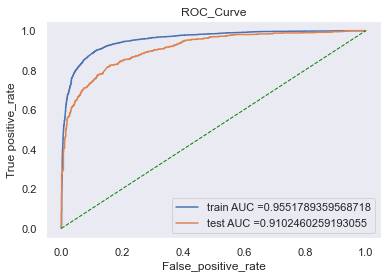

The AUC_score of test_data is : 0.9102460259193055
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1024
           1       0.86      0.77      0.82       979

    accuracy                           0.83      2003
   macro avg       0.83      0.83      0.83      2003
weighted avg       0.83      0.83      0.83      2003



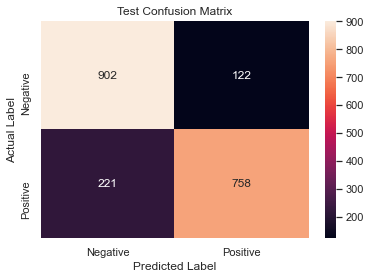

In [86]:
# new model with adjusted hyperparameters 

model4_tuned = LogisticRegression(C = 1.62377, solver = 'lbfgs', penalty = 'l2') # with auc_score

test_data(model4_tuned,Train_tf_idf,Y_train,Test_tf_idf,Y_test)
perform(model4_tuned,Train_tf_idf,Y_train,Test_tf_idf,Y_test)
   



# Summary of Findings   <a class="anchor" id="summary"></a>

In [89]:
from prettytable import PrettyTable 

In [90]:
summary_RF = PrettyTable()
summary_RF.field_names = ["Model","Vectorizer","Optimal Depth", "Optimal n_estimator", "AUC", "F1"]
summary_RF.add_row(["Random Forest","BOW",60,500,88.90,79])
summary_RF.add_row(["Random Forest","TFIDF",70,400,88.52,79])



print(summary_RF)

+---------------+------------+---------------+---------------------+-------+----+
|     Model     | Vectorizer | Optimal Depth | Optimal n_estimator |  AUC  | F1 |
+---------------+------------+---------------+---------------------+-------+----+
| Random Forest |    BOW     |       60      |         500         |  88.9 | 79 |
| Random Forest |   TFIDF    |       70      |         400         | 88.52 | 79 |
+---------------+------------+---------------+---------------------+-------+----+


In [91]:
summary_LR = PrettyTable()
summary_LR.field_names = ["Model","Vectorizer","Solver", "Penalty", "C", "AUC", "F1"]
summary_LR.add_row(["Logistic Regression","BOW",'newton-cg','l2', '0.23357', 89.63, 83])
summary_LR.add_row(["Logistic Regression","TFIDF",'lbfgs','l2', '1.62377', 91.02, 83])
print(summary_LR)

+---------------------+------------+-----------+---------+---------+-------+----+
|        Model        | Vectorizer |   Solver  | Penalty |    C    |  AUC  | F1 |
+---------------------+------------+-----------+---------+---------+-------+----+
| Logistic Regression |    BOW     | newton-cg |    l2   | 0.23357 | 89.63 | 83 |
| Logistic Regression |   TFIDF    |   lbfgs   |    l2   | 1.62377 | 91.02 | 83 |
+---------------------+------------+-----------+---------+---------+-------+----+


# Summary

Overall, we see that the LR Model with TF-IDF Featurization yields the highest AUC score (91.02%) and F1 score. The results show that tuning our hyperparameters as well as comparing different models and featurizations approaches can help achieve higher aucurracy. 